In [2]:
%matplotlib inline

from osgeo import gdal, ogr, osr
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt
import numpy as np
import os

## Explore the National Land Cover Database (NLCD) raster

In [3]:
NLCD = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\NLCD\NLCD2011_LC_New_Jersey\NLCD2011_LC_New_Jersey.tif'

In [4]:
# Check coordinate system and exclude values outside of the land cover classification numbers
with rasterio.open(NLCD) as nlcd_raster:
    crs = nlcd_raster.crs
    nlcd = nlcd_raster.read(1)
    #nlcd = nlcd.astype('f4')
    # Set cells to 0
    nlcd[nlcd>95] = 0

crs
nlcd.dtype

dtype('uint8')

In [5]:
#Identify the count of each value in the raster
(values, counts) = np.unique(nlcd, return_counts=True)
values = dict(zip(values, counts))
values

{0: 14129432,
 11: 3815733,
 21: 3106279,
 22: 1997288,
 23: 1160304,
 24: 522565,
 31: 158763,
 41: 4482318,
 42: 831432,
 43: 756489,
 52: 452705,
 71: 124792,
 81: 929177,
 82: 2069805,
 90: 3640100,
 95: 1050198}

<function matplotlib.pyplot.show(*args, **kw)>

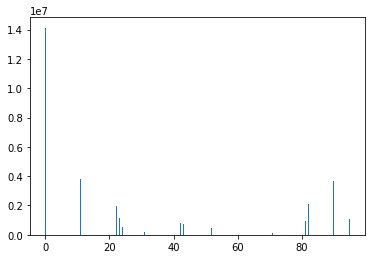

In [6]:
a=np.hstack(nlcd)
plt.hist(a, bins='auto')
plt.show

Text(0,0.5,'Row #')

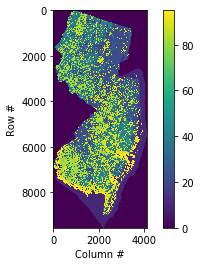

In [7]:
# Map array
plt.imshow(nlcd)
plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')


## Identify only residential land

In [8]:
# Create a function to only identify residential land. These values are provided in the metadata about the NLCD.
res_values =  [22, 23, 24]
non_res_values = [11,12,21,31,41,42,43,51,52,71,72,81,82,90,95]

def identify_res_land(array):
    for val in res_values:
        array[array==val] = 1
    for val in non_res_values:
        array[array==val] = 0
        
    return array

Text(0,0.5,'Row #')

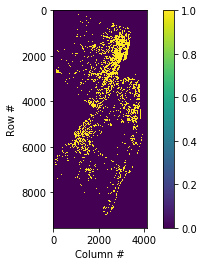

In [9]:
# Map new array
nj_res_land = identify_res_land(nlcd)

plt.imshow(nj_res_land)
leg = plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')

In [10]:
# Preparing to export new array as a raster (GeoTIFF)
out_fp = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_residential.tif'

In [11]:
# If the file exists, delete it
if os.path.exists(out_fp):
    os.remove(out_fp)
else:
    print("Cannot delete the file as it doesn't exists")

In [12]:
# Get original raster's coordinate system and affine transformation
with rasterio.open(NLCD) as source_raster:
    source_crs = source_raster.crs
    source_transform = source_raster.transform
print(source_crs)
print(source_transform)

+datum=NAD83 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +y_0=0
| 30.00, 0.00, 1725255.00|
| 0.00,-30.00, 2236455.00|
| 0.00, 0.00, 1.00|


In [13]:
# Export array to raster(GeoTiff)
with rasterio.open(out_fp, 'w', driver='GTiff',
                   height=nj_res_land.shape[0], # Number of rows
                   width=nj_res_land.shape[1], # Number of columns
                   count=1, # Number of bands
                   dtype=nj_res_land.dtype, # This must match the datatpe of the array
                   crs=source_crs,
                   transform=source_transform
                  ) as out_raster:
    out_raster.write(nj_res_land, 1)
    out_raster.nodata = -1 # Set the raster's nodata value

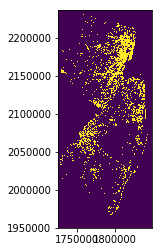

In [14]:
# Map and examine new raster
exported = rasterio.open(out_fp)
rasterio.plot.show(exported)

## Crop raster for experimentation

Since I was coming across some problems converting the raster into polygons and gdal.Polygonize() was quite slow, I clipped the raster in order to experiment on a smaller dataset.

In [15]:
original = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_residential.tif'
clip = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_res_clip.tif'
data = rasterio.open(original)

In [16]:
# WGS84 coordinates for clipping
minx, miny = -74.5, 40.6
maxx, maxy = -74.4, 40.7
bbox = box(minx, miny, maxx, maxy) 

In [17]:
# Insert the box into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

In [18]:
# Re-project into the same coordinate system as the raster data
geo = geo.to_crs(crs=data.crs.data)

In [19]:
# Convert features into a rasterio-friendly format
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [20]:
coords = getFeatures(geo)

In [21]:
print(coords)

[{'type': 'Polygon', 'coordinates': [[[1797005.1113295236, 2159297.929032296], [1794481.2551049404, 2170210.22517387], [1786316.0355077754, 2168326.253248254], [1788828.407722566, 2157411.307385901], [1797005.1113295236, 2159297.929032296]]]}]


In [22]:
# Clip raster based on mask data
from rasterio.mask import mask
out_img, out_transform = mask(data, shapes=coords, crop=True)

In [23]:
# Now need to modify the metadata
out_meta = data.meta.copy()
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4105,
 'height': 9556,
 'count': 1,
 'crs': CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}),
 'transform': Affine(30.0, 0.0, 1725255.0,
        0.0, -30.0, 2236455.0)}

In [24]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})

In [25]:
with rasterio.open(clip, 'w', **out_meta) as dest:
    dest.write(out_img)

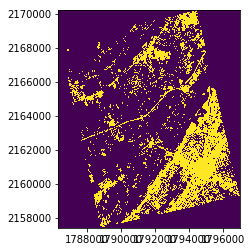

In [26]:
clip_raster = rasterio.open(clip)
rasterio.plot.show(clip_raster)

## Polygonize the new raster

In [27]:
gdal.UseExceptions

<function osgeo.gdal.UseExceptions(*args)>

In [29]:
# Get raster datsource
sourceRaster = gdal.Open(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\nj_residential.tif')
sr_proj=sourceRaster.GetProjection()
raster_proj = osr.SpatialReference()
raster_proj.ImportFromWkt(sr_proj)

0

In [30]:
band = sourceRaster.GetRasterBand(1) 
bandArray = band.ReadAsArray()

In [31]:
outShapefile = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\nj_residential'

In [32]:
driver = ogr.GetDriverByName("ESRI Shapefile")
outDatasource = driver.CreateDataSource(outShapefile+ ".shp")
outLayer = outDatasource.CreateLayer('polygonized', srs=raster_proj)
newField = ogr.FieldDefn('LandType', ogr.OFTInteger)
outLayer.CreateField(newField)

gdal.Polygonize( band, None, outLayer, 0, [], callback=None )
outDatasource.Destroy()
sourceRaster = None

In [33]:
res_geodata = gpd.read_file(outShapefile + '.shp')
res_geodata.head(5)

,LandType,geometry
0,1,"POLYGON ((1754025 2236455, 1754055 2236455, 17..."
1,1,"POLYGON ((1754055 2236425, 1754145 2236425, 17..."
2,1,"POLYGON ((1754385 2236305, 1754445 2236305, 17..."
3,1,"POLYGON ((1754085 2236275, 1754205 2236275, 17..."
4,1,"POLYGON ((1754205 2236215, 1754295 2236215, 17..."


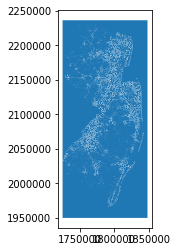

In [38]:
# Plot the new file
fig, ax = plt.subplots()
res_geodata.plot(ax=ax,)

plt.show()